# Advanced time series forecasting with FEDOT. Guide
#### FEDOT version = 0.6.1

In [1]:
pip install fedot==0.6.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This tutorial was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

Below is an example of how you can use advanced ways to configure FEDOT for a time series forecasting task.

If you want to learn some basic things about FEDOT and time series forecasting, you can use [this notebook](3_intro_ts_forecasting.ipynb).

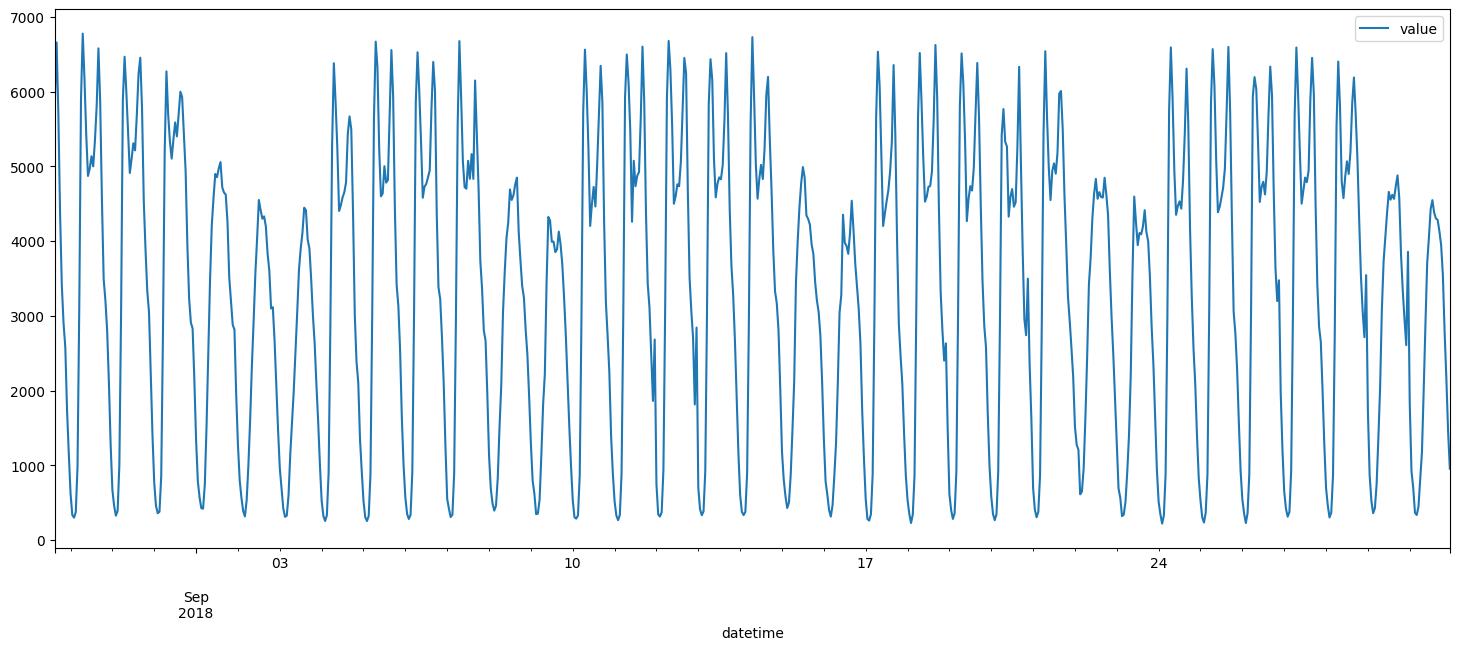

Length of the time series - 801


In [2]:
# Additional imports 
import pandas as pd 
import numpy as np

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import logging
logging.raiseExceptions = False

# Import data
df = pd.read_csv('../data/ts_traffic.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# Plot data
df.plot('datetime', 'value')
plt.show()

print(f'Length of the time series - {len(df)}')

Data: hourly traffic volume values. From the plot, you can see 2 peaks for each cycle: morning and evening, as well as a decrease in traffic on weekends.

## Manualy created pipeline

In [3]:
# Pipeline and nodes
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# Metric
from sklearn.metrics import mean_absolute_error

Let's imagine that we need to predict the traffic volume for 72 hours ahead.

In [4]:
forecast_length = 72

In [5]:
# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))

# Get time series from dataframe
traffic = np.array(df['value'])
input_data = InputData(idx=np.arange(0, len(traffic)),
                       features=traffic,
                       target=traffic,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Split data into train and test
train_input, predict_input = train_test_data_setup(input_data)

Let's create a function for configuring complex pipelines and a function to plot results.

In [6]:
def get_two_branches_pipeline(lagged_param_1=10, lagged_param_2=10,
                              model_1='ridge', model_2='ridge', model_3='ridge'):
    """
    Pipeline looking like this
    lagged -> model_1 \
                       \
                        model_3 -> final forecast
                       /
    lagged -> model_2 /
    """
    # First level
    node_lagged_1 = PrimaryNode('lagged')
    node_lagged_1.parameters = {'window_size': lagged_param_1}
    node_lagged_2 = PrimaryNode('lagged')
    node_lagged_2.parameters = {'window_size': lagged_param_2}

    # Second level
    node_second_1 = SecondaryNode(model_1, nodes_from=[node_lagged_1])
    node_second_2 = SecondaryNode(model_2, nodes_from=[node_lagged_2])

    # Third level - root node
    node_final = SecondaryNode(model_3, nodes_from=[node_second_1, node_second_2])
    pipeline = Pipeline(node_final)
    
    return pipeline


def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()

This time series is quite simple for an expert to interpret. So we can use our knowledge of cycling to set the lags manually.

Lags here are:
* 144 elements
* 12 elements 

In [7]:
# Initialise pipeline for making forecasting
pipeline = get_two_branches_pipeline(lagged_param_1=144, 
                                     lagged_param_2=12)

# Fit
pipeline.fit(train_input)

# Make forecast
output = pipeline.predict(predict_input)
forecast = np.ravel(np.array(output.predict))

c:\users\valery\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Manual pipeline forecast

Using the trained model, we will give a forecast for 72 elements ahead.

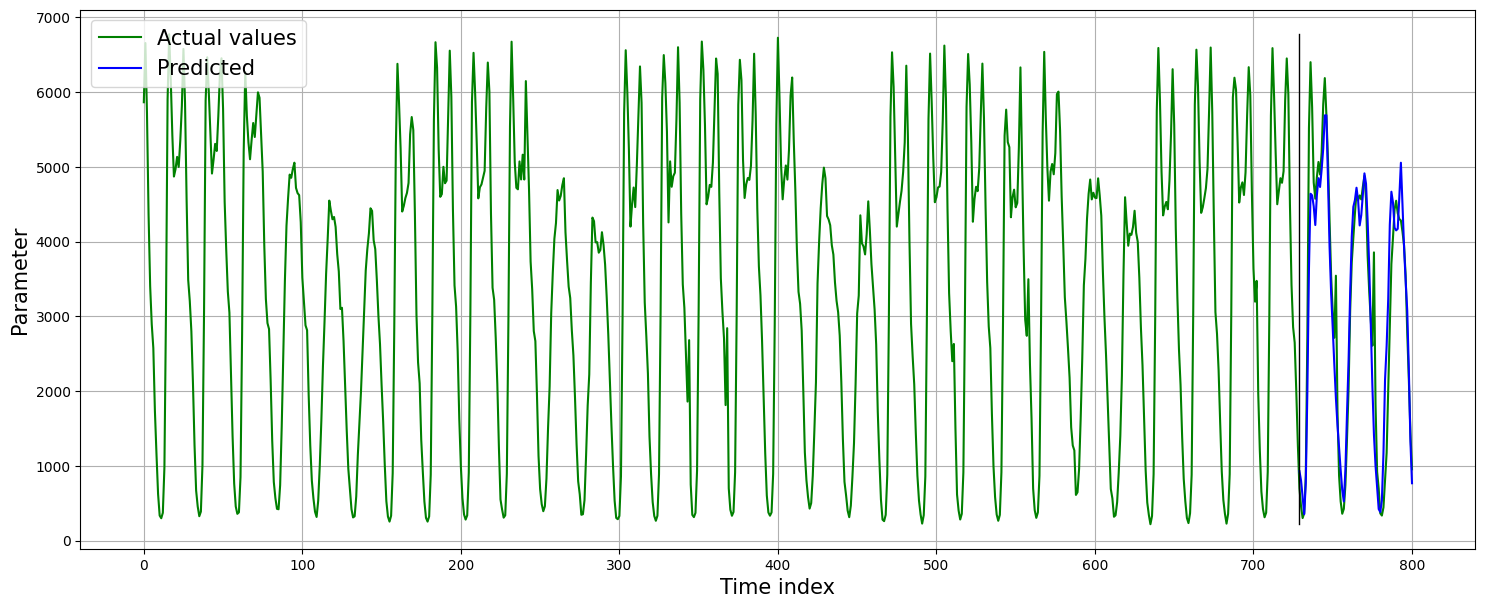

Mean absolute error: 454.551


In [8]:
plot_results(actual_time_series = traffic,
             predicted_values = forecast, 
             len_train_data = len(traffic)-forecast_length)

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(predict_input.target, forecast):.3f}')

To complicate the task, imagine that we don't know anything about the time series structure. Let's try to find optimal parameters using the algorithm for configuring hyperparameters in the nodes.

## Hyperparameters tuning

To configure hyperparameters, you can use 2 approaches: sequential (1) and simultaneous (2) tuning. Below are the animations of how the hyperparameters optimization is performed.

<img src="../jupyter_media/time_series/sequental_tuning.gif" width="500"/>

(1) Animation of sequential tuning

<img src="../jupyter_media/time_series/chain_tuning.gif" width="500"/>

(2) Animation of simultaneous tuning

Below, we will use the PipelineTuner class (and TunerBuilder class) to configure hyperparameters in the pipeline nodes. This classes allows configuring hyperparameters in the nodes using simultaneous tuning.

In [9]:
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.repository.quality_metrics_repository import \
    MetricsRepository, RegressionMetricsEnum


init_pipeline = get_two_branches_pipeline()

# Start tuning all nodes in the pipeline 
tuner = TunerBuilder(train_input.task)\
        .with_tuner(PipelineTuner)\
        .with_metric(RegressionMetricsEnum.MAE)\
        .with_iterations(50) \
        .build(train_input)
tuned_pipeline = tuner.tune(init_pipeline)

#final fit
tuned_pipeline.fit(train_input)




2022-12-20 15:57:31,711 - DataSourceSplitter - Hold out validation is applied.
2022-12-20 15:57:31,713 - PipelineTuner - Hyperparameters optimization start
2022-12-20 15:57:31,944 - PipelineTuner - Initial pipeline: {'depth': 3, 'length': 5, 'nodes': [ridge, ridge, lagged, ridge, lagged]}
ridge - {}
ridge - {}
lagged - {'window_size': 10}
ridge - {}
lagged - {'window_size': 10} 
Initial metric: 849.830
  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]2022-12-20 15:57:31,949 - build_posterior_wrapper took 0.001000 seconds
2022-12-20 15:57:31,950 - TPE using 0 trials
 20%|██████████▏                                        | 1/5 [00:00<00:00,  4.90trial/s, best loss: 849.8297273922445]2022-12-20 15:57:32,156 - build_posterior_wrapper took 0.002012 seconds
2022-12-20 15:57:32,157 - TPE using 1/1 trials with best loss 849.829727
 40%|████████████████████▍                              | 2/5 [00:00<00:00,  4.96trial/s, best

 58%|████████████████████████████▍                    | 29/50 [00:29<00:31,  1.49s/trial, best loss: 273.2404635359539]2022-12-20 15:58:02,117 - build_posterior_wrapper took 0.002003 seconds
2022-12-20 15:58:02,117 - TPE using 29/29 trials with best loss 273.240464
 60%|█████████████████████████████▍                   | 30/50 [00:30<00:25,  1.29s/trial, best loss: 273.2404635359539]2022-12-20 15:58:02,964 - build_posterior_wrapper took 0.001002 seconds
2022-12-20 15:58:02,966 - TPE using 30/30 trials with best loss 273.240464
 62%|██████████████████████████████▍                  | 31/50 [00:32<00:30,  1.62s/trial, best loss: 273.2404635359539]2022-12-20 15:58:05,341 - build_posterior_wrapper took 0.001009 seconds
2022-12-20 15:58:05,343 - TPE using 31/31 trials with best loss 273.240464
 64%|███████████████████████████████▎                 | 32/50 [00:32<00:23,  1.28s/trial, best loss: 273.2404635359539]2022-12-20 15:58:05,826 - build_posterior_wrapper took 0.001005 seconds
2022-12-20 

OutputData(idx=array([482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
       573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624,
       625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637,
       638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650,
       651, 652, 653, 654, 655, 656, 657]), task=

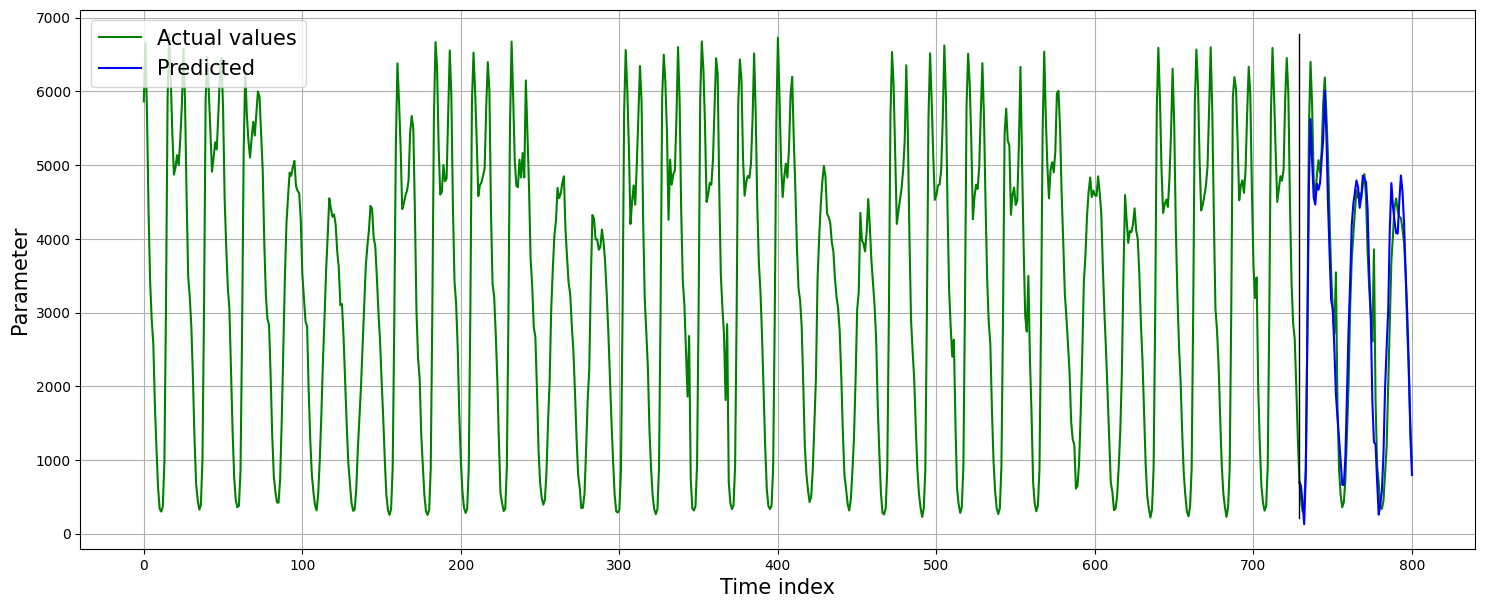

Mean absolute error: 411.513


In [10]:
# Make prediction
tuned_output = tuned_pipeline.predict(predict_input)
tuned_forecast = np.ravel(np.array(tuned_output.predict))


plot_results(actual_time_series = traffic,
             predicted_values = tuned_forecast, 
             len_train_data = len(traffic)-forecast_length)

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(predict_input.target, tuned_forecast):.3f}')

Let's look at the hyperparameters found in the nodes. 

In [11]:
tuned_pipeline.print_structure()

Pipeline structure:
{'depth': 3, 'length': 5, 'nodes': [ridge, ridge, lagged, ridge, lagged]}
ridge - {'alpha': 4.535080274292746}
ridge - {'alpha': 7.217929516588094}
lagged - {'window_size': 27}
ridge - {'alpha': 6.439829936773009}
lagged - {'window_size': 482}


Thus, when using optimization, we were able to surpass the "expert approach" to determining hyperparameters.

But what if we do not know not only nothing about the appropriate parameters in the nodes, but also do not know what structure the pipeline should be for forecasting. In this case, we can use composer.

## Time series pipeline composing

To predict time series, as well as for other tasks, we can use the FEDOT framework API (simple approach), or build models based on internal core methods (advanced approach).

### Simple approach (API example)

In [12]:
from fedot.api.main import Fedot

Start model composition via the API

In [13]:
# Define parameters
task_parameters = TsForecastingParams(forecast_length=forecast_length)

# Init model for the time series forecasting
model = Fedot(problem='ts_forecasting', task_params=task_parameters, timeout=1)

# Run AutoML model design in the same way
pipeline = model.fit(features=train_input)

2022-12-20 15:58:31,981 - ApiComposer - Initial pipeline was fitted in 0.2 sec.
2022-12-20 15:58:31,986 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['adareg', 'ar', 'arima', 'clstm', 'dtreg', 'gbr', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'polyfit', 'sgdr', 'stl_arima', 'glm', 'ets', 'locf', 'ts_naive_average', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter', 'diff_filter', 'cut', 'exog_ts'].
2022-12-20 15:58:31,990 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 16:03:42,533 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [05:10<?, ?gen/s]

2022-12-20 16:03:42,547 - ApiComposer - Time for pipeline composing was 0:05:10.554668.
The remaining 4.2 seconds are not enough to tune the hyperparameters.
2022-12-20 16:03:42,550 - ApiComposer - Composed pipeline returned without tuning.


2022-12-20 16:03:42,839 - ApiComposer - Model generation finished
2022-12-20 16:04:00,155 - FEDOT logger - Final pipeline was fitted
2022-12-20 16:04:00,157 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, glm, gbr, lagged]}
ridge - {}
glm - {'family': 'gaussian', 'link': 'identity'}
gbr - {}
lagged - {'window_size': 10}


In [14]:
# Use model to obtain forecast
forecast = model.forecast(predict_input)

In [15]:
print(forecast.shape)

(72,)


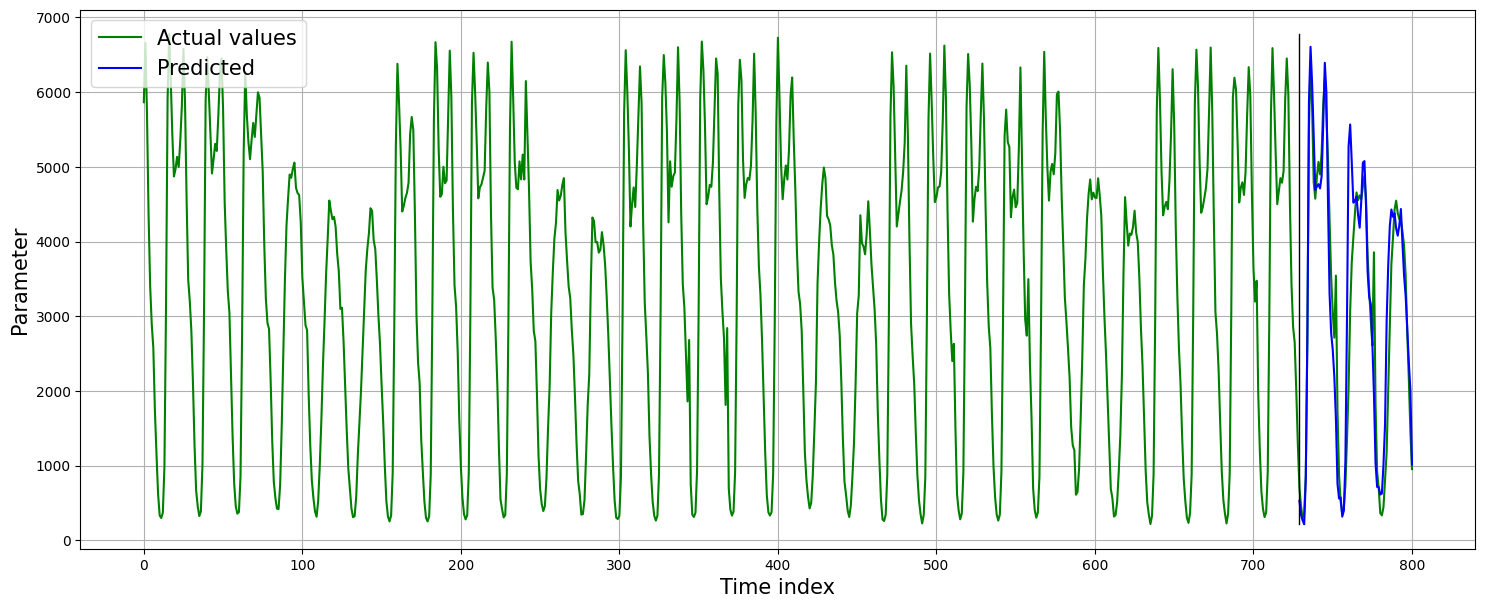

In [16]:
# Plot results 
plot_results(actual_time_series = traffic,
             predicted_values = forecast, 
             len_train_data = len(traffic)-forecast_length)

In [17]:
# Print metrics for validation part
model.get_metrics(metric_names=['rmse', 'mae', 'mape', 'smape'], target=predict_input.target)

{'rmse': 787.326, 'mae': 489.509, 'mape': 0.255, 'smape': 21.71}

### Advanced approach (сore-based example)

We will use lower-level methods below. We will write more code, but this will help us better understand the framework abilities as well as allow using the advanced functionality of the library.

In [18]:
import datetime

from fedot.core.data.data import InputData
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.repository.dataset_types import DataTypesEnum

# Evolutionary algorithm classes 
from fedot.core.optimisers.gp_comp.operators.mutation import MutationTypesEnum
from fedot.core.composer.gp_composer.specific_operators import parameter_change_mutation
from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.composer.gp_composer.gp_composer import PipelineComposerRequirements
from fedot.core.optimisers.gp_comp.operators.inheritance import GeneticSchemeTypesEnum
from fedot.core.optimisers.gp_comp.gp_params import GPGraphOptimizerParameters
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum
from fedot.core.repository.quality_metrics_repository import MetricsRepository, RegressionMetricsEnum

We can determine which models and data operations we will use to predict the time series, in this case we will use:
* lagged - lagged transformation time series into table form;
* sparse_lagged - lagged transformation time series into table form and reducing the number of lags (columns) with matrix decomposition;
* smoothing - moving average smoothing of time series;
* gaussian_filter - smoothing of time series;
* ar - two-lag autoregression model;


* ridge - ridge regression;
* lasso - lasso regression;
* linear - linear model;
* knnreg - regression based on k-nearest neighbors;
* dtreg - decision tree regression;
* scaling - scaling operation;
* rfe_lin_reg - feature ranking with recursive feature elimination with linear regression as base estimator;
* rfe_non_lin_reg - feature ranking with recursive feature elimination with decision tree regression as base estimator.

In [19]:
primary_operations = ['sparse_lagged', 'lagged', 'smoothing', 'gaussian_filter', 'ar']
secondary_operations = ['sparse_lagged', 'lagged', 'ridge', 'lasso', 'knnreg', 'dtreg', 
                        'linear', 'scaling', 
                        'rfe_lin_reg', 'rfe_non_lin_reg']

Define the parameters for the composer - set the number of generations, determine the maximum possible depth of the pipelines, and so on:

In [20]:
# Composer parameters
timeout = datetime.timedelta(minutes=1)
composer_requirements = PipelineComposerRequirements(
    primary=primary_operations,
    secondary=secondary_operations, 
    max_arity=3,
    max_depth=8, 
    num_of_generations=20,
    timeout=timeout, 
    cv_folds=2,
    validation_blocks=2)

TypeError: __init__() got an unexpected keyword argument 'validation_block'

### Hyperparameters search during composing

In FEDOT, an evolutionary algorithm is responsible for creating pipelines. This evolutionary algorithm generates an initial population consisting of pipelines, and then applies mutation, selection, and crossover operators to find the optimal solution.

At the same time, there are a very large number of modifications of the evolutionary algorithm. For example, you can use only one mutation operator, or use a specific scheme (for example, $\mu+\lambda$). And FEDOT allows you to do so.

Let's look at a specific example. In FEDOT, there are several mutation operators, namely:   
* simple - this type of mutation is passed over all nodes of the tree started from the root node and replace operations in the nodes with new ones;
* growth - this mutation selects a random node in a tree, generates new subtree, and replaces the selected node's subtree;
* local_growth - as "growth", but maximal depth of new subtree equals depth of tree located in;
* reduce - selects a random node in a tree, then removes its subtree. If the current arity of the node's parent is more than the specified minimal arity, then the selected node is also removed;

Specific mutation:
* parameter_change_mutation - this type of mutation is passed over all nodes and changes hyperpearameters of the operations; 

Below, we will only use the parameter_change, simple, and reduce operators.

In [21]:
mutation_types = [parameter_change_mutation, MutationTypesEnum.simple, MutationTypesEnum.reduce]
optimiser_parameters = GPGraphOptimizerParameters(mutation_types=mutation_types)

Let's set the metric for optimization - MAE. And run the algorithm to find the optimal solution.

*Due to the specifics of the jupyter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

Generations:   5%|███▊                                                                         | 1/20 [00:00<?, ?gen/s]

2022-12-20 16:05:03,065 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   5%|███▊                                                                         | 1/20 [01:01<?, ?gen/s]


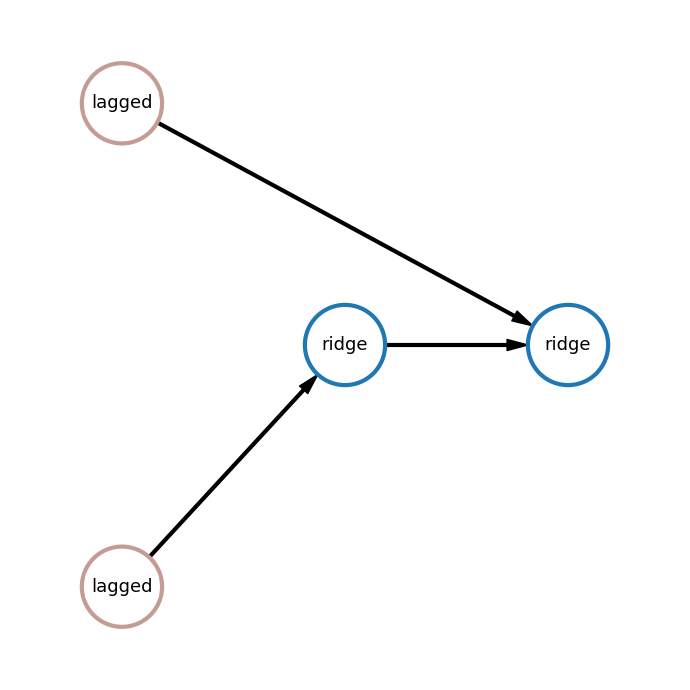

In [22]:
metric_function = MetricsRepository().metric_by_id(RegressionMetricsEnum.MAE)
builder = ComposerBuilder(task=task). \
    with_optimizer_params(parameters=optimiser_parameters).\
    with_requirements(composer_requirements).\
    with_metrics(metric_function).with_initial_pipelines([init_pipeline])
composer = builder.build()

obtained_pipeline = composer.compose_pipeline(data=train_input)
obtained_pipeline.show()

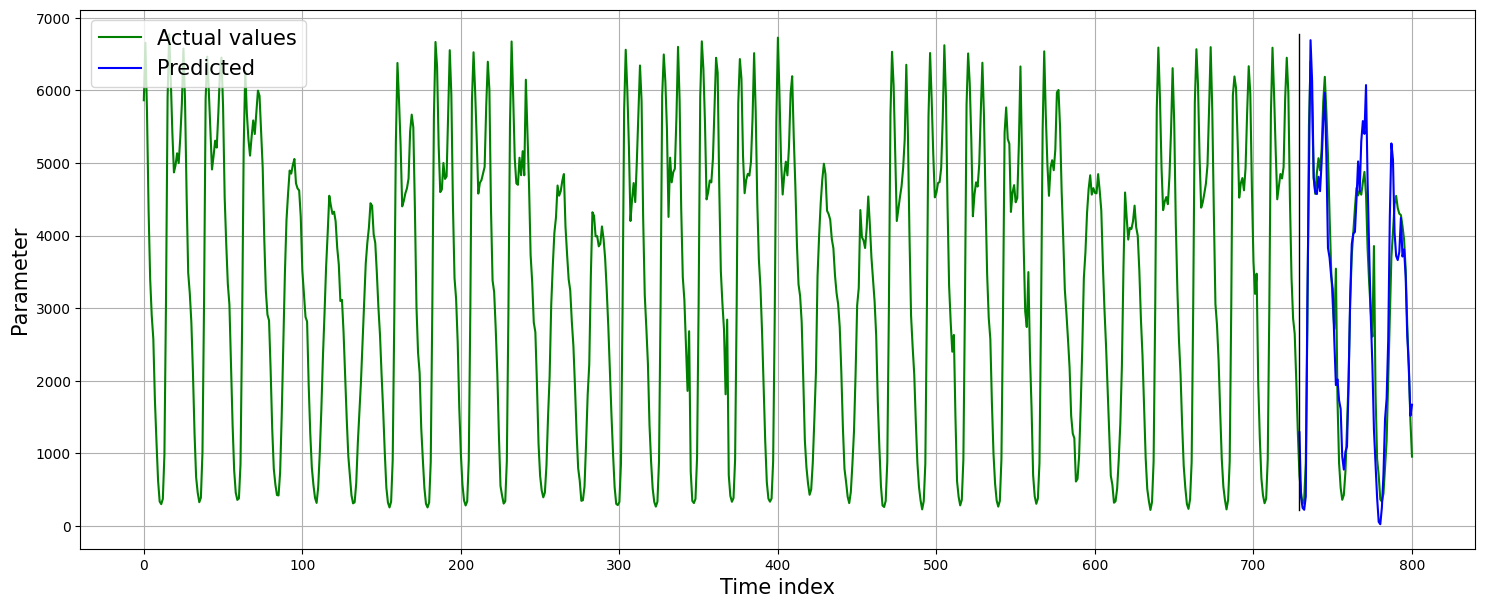

Mean absolute error: 482.113


In [23]:
# Fit pipeline on the entire dataset
obtained_pipeline.fit(train_input)

# Make prediction
obtained_output = obtained_pipeline.predict(predict_input)
obtained_forecast = np.ravel(np.array(obtained_output.predict))


plot_results(actual_time_series = traffic,
             predicted_values = obtained_forecast, 
             len_train_data = len(traffic)-forecast_length)

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(predict_input.target, obtained_forecast):.3f}')

As you can see from the metric value, we were able to improve the accuracy of forecasting with help of composer.

## Pipeline visualization. Import and export

Now we visualize the pipeline - let's see how the nodes with operations are connected with each other.

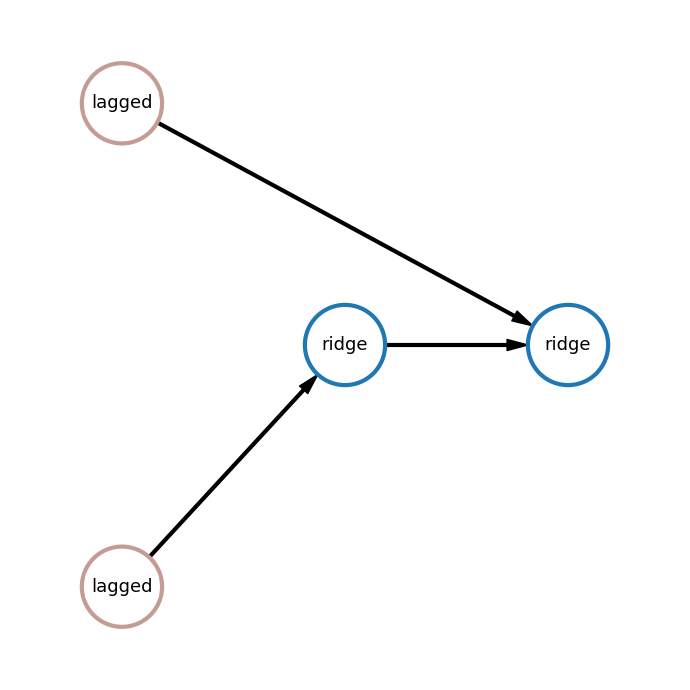

In [24]:
obtained_pipeline.show()

Now let's see what hyperparameters are in the nodes.

In [25]:
# Print hyperparameters for all nodes
obtained_pipeline.print_structure()

Pipeline structure:
{'depth': 3, 'length': 4, 'nodes': [ridge, lagged, ridge, lagged]}
ridge - {'alpha': 4.535080274292746}
lagged - {'window_size': 10}
ridge - {'alpha': 6.439829936773009}
lagged - {'window_size': 359}


Now let's save the pipeline. The pipeline will be saved to the "jupyter_media/models" folder and a folder "January-03-2022,01-20-01,AM" (in this case) will be automatically generated. The name of this folder will depend on the current time.

In [26]:
# Export it
obtained_pipeline.save(path='../jupyter_media/models/')

('{\n    "total_pipeline_operations": [\n        "lagged",\n        "ridge"\n    ],\n    "depth": 3,\n    "nodes": [\n        {\n            "operation_id": 1,\n            "operation_type": "lagged",\n            "operation_name": "LaggedTransformationImplementation",\n            "custom_params": {\n                "window_size": 10\n            },\n            "params": {\n                "window_size": 10\n            },\n            "nodes_from": [],\n            "fitted_operation_path": [\n                "fitted_operations",\n                "operation_1.pkl"\n            ],\n            "rating": null\n        },\n        {\n            "operation_id": 3,\n            "operation_type": "lagged",\n            "operation_name": "LaggedTransformationImplementation",\n            "custom_params": {\n                "window_size": 359\n            },\n            "params": {\n                "window_size": 359\n            },\n            "nodes_from": [],\n            "fitted_opera

The saved pipeline can be loaded and used for predictions, you can do this with the following command:

In [27]:
# Import pipeline 
load_pipeline = Pipeline()
load_pipeline.load('../jupyter_media/models/March-29-2022,11-48-52,AM\.json')

{'depth': 2, 'length': 2, 'nodes': [ridge, lagged]}

Today we learned how to use FEDOT to predict time series using advanced methods in our framework. We used the tool to set up hyperparameters in the nodes of the composite model, and we also learned how to run the composer for creating pipelines. We also figured out what mutation operators are in the framework and learned how to choose ones you needed and use them.